<a href="https://colab.research.google.com/github/gutifer666/asignar-instalaciones/blob/main/asignaci%C3%B3n_de_instalaciones_y_enrutamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programación de producción y transporte
## Descripción del problema:
* Asignar un conjunto dado de pedidos a plantas y transportistas para minimizar costos.
  * Seleccionar la planta apropiada que procesa el pedido.
  * Seleccionar el puerto desde el cual se enviará el pedido a su destino.
* Restricciones:
  * Una planta determinada solo puede procesar ciertos productos.
  * Cada planta solo está conectada a ciertos puertos. (ver Mapeo de cadena de suministro a continuación.)
  * Algunos clientes tienen un inventario gestionado por el proveedor (VMI), lo que significa que solo pueden ser atendidos por una planta específica.

## Implementación del código

## Carda de Datos y Gráficos

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
! pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


El siguiente código carga varios archivos CSV desde un archivo Excel y los guarda como DataFrames de Pandas. Luego, cambia el nombre de las columnas en algunos de los DataFrames para eliminar espacios y los reemplaza con guiones bajos. Finalmente, establece el índice del DataFrame "wh_cost" en la columna "WH" utilizando el método "set_index()" de Pandas.

In [2]:
# lee en todos los ficheros CSV
file = pd.ExcelFile("Supply chain logisitcs problem.xlsx")
plant_ports = file.parse("PlantPorts")# pd.read_csv("Supply chain logistics problem.xlsx.csv", index_col=0)
order_list = file.parse("OrderList")# , index_col=0)
products_plants = file.parse("ProductsPerPlant")# , index_col=0)
vmi_plants = file.parse("VmiCustomers") # index_col=0)
freight_rates = file.parse("FreightRates") # , index_col=0)
wh_cost = file.parse("WhCosts") # , index_col=0)

# camvia los nombres de las columnas
order_list.columns = [i.replace(" ", "_") for i in order_list.columns]
products_plants.columns = [i.replace(" ", "_") for i in products_plants.columns]
plant_ports.columns = [i.replace(" ", "_") for i in plant_ports.columns]
vmi_plants.columns = [i.replace(" ", "_") for i in vmi_plants.columns]

wh_cost.set_index("WH", inplace=True)

La siguiente línea de código utiliza la función "from_pandas_edgelist()" de la biblioteca NetworkX para crear un grafo a partir de un DataFrame de Pandas llamado "plant_ports". Se especifica que la columna "Plant_Code" se utilizará como nodo origen y la columna "Port" se utilizará como nodo destino en cada arista del grafo creado. El grafo resultante se asigna a la variable "plant_ports_graph".

In [3]:
plant_ports_graph = nx.from_pandas_edgelist(plant_ports, source="Plant_Code", target="Port")

## Mapeo de la Cadena de Suministro

### Forma No Interactiva con Networkx

Este código utiliza la biblioteca Matplotlib para crear un gráfico de la cadena de suministro a partir del grafo "plant_ports_graph". Primero, se establece el tamaño del gráfico y se establece el color de fondo. A continuación, se especifica el diseño del grafo utilizando el algoritmo de diseño bipartito de NetworkX, que asigna nodos a dos conjuntos separados y los coloca en lados opuestos del gráfico. Luego, se ajusta la posición de los nodos para mejorar la legibilidad del gráfico.

A continuación, se calcula el grado de cada nodo y se utiliza para asignar un tamaño y un color al nodo en el gráfico. Se especifica un mapa de colores de Matplotlib para mapear el rango de valores del grado del nodo al rango de colores del mapa.

Finalmente, se utilizan las funciones de dibujo de NetworkX para dibujar los nodos, las aristas y las etiquetas del grafo en el gráfico de Matplotlib, y se muestra el gráfico resultante

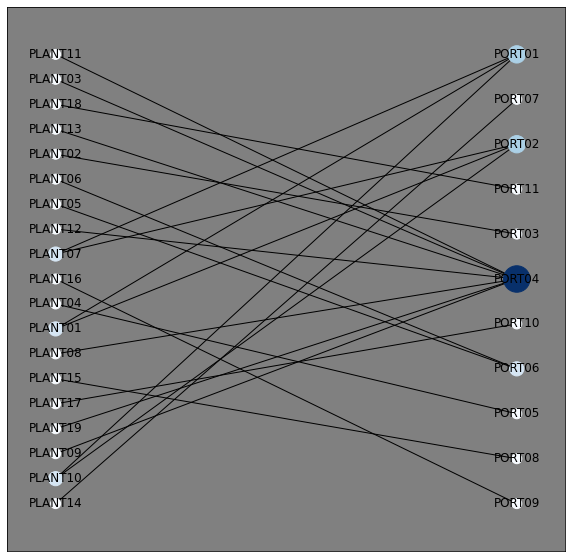

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor("Grey")

# especifica el layoyt para el gráfico

layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant_Code"])

for i in layout:
    if i.startswith("PLANT"):
        layout[i][0] -= 0.1
    else:
        layout[i][0] += 0.1

# queremos asignar un color/tamaño al nodo según su grado.
degrees = dict(plant_ports_graph.degree)
maps = [v*100 for v in degrees.values()]

# especificar el mapa de colores
cmap = plt.cm.Blues

# argumentos de palabra clave que son los mismos para ambas funciones
kwargs = {"pos":layout, "ax":ax}

nx.draw_networkx_nodes(plant_ports_graph, node_size=maps, node_color=maps, cmap=cmap, **kwargs)
nx.draw_networkx_edges(plant_ports_graph, **kwargs)
nx.draw_networkx_labels(plant_ports_graph, pos=layout)
plt.show()

### Versión Interactiva con [Plotly](https://plotly.com/python/network-graphs/)

Este siguiente código crea una visualización interactiva del grafo de la cadena de suministro utilizando la biblioteca Plotly. Primero, utiliza la misma función "bipartite_layout()" de NetworkX para crear el diseño del grafo.

A continuación, itera sobre las aristas del grafo y obtiene las coordenadas x e y de los nodos de inicio y fin de cada arista. Luego, agrega estas coordenadas a las listas "edge_x" y "edge_y" respectivamente, y también agrega "None" a estas listas para separar cada segmento de línea.

Finalmente, se utiliza la función "go.Scatter()" de Plotly para crear una traza de la línea de borde para las aristas del grafo. Esta traza se configura para tener un ancho de línea de 0.5 y un color azul oscuro, y se define como un modo de línea en el que no se muestra información de herramientas al pasar el cursor sobre la línea.

In [5]:
# obtener los puntos de inicio y finalización de las aristas y agregarlos al grafo
layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant_Code"])

edge_x = []
edge_y = []

for edge in plant_ports_graph.edges():
    x0, y0 = layout[edge[0]]
    x1, y1 = layout[edge[1]]
    
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#25488e'),
    hoverinfo='none',
    mode='lines')

El siguiente código también utiliza la biblioteca Plotly para crear una visualización interactiva del grafo de la cadena de suministro. Primero, se itera sobre los nodos del grafo y se obtienen las coordenadas x e y de cada nodo a partir del diseño del grafo.

A continuación, se crea una traza de puntos para los nodos del grafo utilizando la función "go.Scatter()" de Plotly. Se especifica que los puntos deben mostrar información de herramientas al pasar el cursor sobre ellos y se establece el tamaño y el color de los puntos según el grado de cada nodo.

Se configura un mapa de colores de Plotly y se utiliza una barra de colores para indicar la escala de colores para el tamaño de los puntos. También se agrega un texto a cada punto que muestra el número de enlaces para ese nodo.

En conjunto, el código crea una visualización interactiva del grafo de la cadena de suministro que muestra tanto las aristas como los nodos, con información adicional disponible al pasar el cursor sobre los puntos y líneas del grafo.

In [6]:
# obtener las coordenadas de los nodos y agregarlos al grafo

node_x = []
node_y = []
for node in plant_ports_graph.nodes():
    x, y = layout[node]
    node_x.append(x)
    node_y.append(y)
    
maps = [v for v in degrees.values()]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=maps,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_trace.text = [i + " Number of Links: " + str(degrees[i]) for i in degrees]

El siguiente código crea la figura final utilizando la biblioteca Plotly. La figura se compone de la traza de las aristas del grafo ("edge_trace") y la traza de los nodos del grafo ("node_trace").

Se configura la presentación de la figura con un título, un tamaño de fuente de título, sin leyenda, un modo de visualización de información de herramientas al pasar el cursor, un margen alrededor de la figura y anotaciones para los nombres de los conjuntos de nodos (fábricas y puertos).

También se configuran los ejes x e y para mostrar las etiquetas de los ejes y las líneas de la cuadrícula, pero no la línea cero.

En conjunto, el código crea una figura interactiva que muestra la cadena de suministro con nodos y aristas de manera clara y legible, con información adicional disponible al pasar el cursor sobre los puntos y líneas del grafo.

In [7]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Supply Chain',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[dict(text="Factories",
                     showarrow=False,
                     xref="paper", yref="paper",
                     x=0.005, y=-0.002 ),
                             dict(text="Ports",
                     showarrow=False,
                     xref="paper", yref="paper",
                     x=0.95, y=-0.002 )],
                xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                yaxis=dict(showgrid=True, zeroline=False, showticklabels=True))
                )
fig

La mayoría de las instalaciones tienen solo una conexión con un puerto. El puerto 4 es potencialmente el más importante ya que tiene la mayoría de las conexiones con los almacenes.

### Preparando la tabla de pedidos

La tabla de pedidos existente ya contiene una solución. Eliminaremos esas columnas

Este código crea una nueva tabla de pedidos llamada "order_new" a partir de la tabla de pedidos existente "order_list". Primero, se eliminan varias columnas de la tabla de pedidos existente utilizando el método "drop()" de Pandas. Las columnas eliminadas son "Order_Date", "Origin_Port", "Carrier", "Plant_Code", "TPT", "Service_Level", "Ship_ahead_day_count" y "Ship_Late_Day_count".

A continuación, se establece el índice de la nueva tabla de pedidos en la columna "Order_ID" utilizando el método "set_index()" de Pandas. Finalmente, se guarda la nueva tabla de pedidos como un archivo CSV llamado "order_new.csv" utilizando el método "to_csv()" de Pandas.

In [8]:
order_new = order_list.drop(columns=["Order_Date", "Origin_Port", "Carrier", "Plant_Code", "TPT", "Service_Level", "Ship_ahead_day_count", "Ship_Late_Day_count"])
order_new.set_index("Order_ID", inplace=True)
order_new.to_csv("order_new.csv")

### Preparando la tabla de envíos

Este código elimina algunas columnas de la tabla de tarifas de envíos "freight_rates" utilizando el método "drop()" de Pandas. Las columnas eliminadas son "dest_port_cd", "Carrier type" y "svc_cd". Luego, se guarda la tabla de tarifas de envíos modificada como un archivo CSV llamado "FreightRates_mod.csv" utilizando el método "to_csv()" de Pandas.

In [9]:
freight_rates.drop(columns=["dest_port_cd", "Carrier type", "svc_cd"], inplace=True)
freight_rates.to_csv("FreightRates_mod.csv")

### Restricciones del Problema

Este código define una función llamada "product_restriction" que toma un índice como argumento y devuelve un array NumPy con los códigos de las plantas que pueden producir el producto correspondiente al pedido con ese índice.

Dentro de la función, se obtiene el registro correspondiente al pedido con el índice dado a partir de la tabla de pedidos "order_new". A continuación, se extrae el ID del producto de este registro y se busca en la tabla de "products_plants" las filas correspondientes a este ID de producto. Se devuelve un array NumPy con los códigos de las plantas que pueden producir el producto.

In [10]:
# dado el id de un producto, devuelve las plantas que pueden producir tal producto
def product_restriction(index):
    data = order_new.loc[index]
    product_id = data["Product_ID"]
    possible_plants = products_plants.loc[products_plants["Product_ID"] == product_id]
    return np.array(possible_plants["Plant_Code"])

Este código define una función llamada "customer_restriction" que toma un índice como argumento y devuelve un array NumPy con los códigos de las plantas que pueden servir al cliente correspondiente al pedido con ese índice.

Dentro de la función, se obtiene el registro correspondiente al pedido con el índice dado a partir de la tabla de pedidos "order_new". A continuación, se extrae el ID del cliente de este registro y se busca en la tabla de "vmi_plants" las filas correspondientes a este ID de cliente. Si no se encuentra ninguna fila para este cliente, se devuelve un array NumPy con todos los códigos de planta y puerto de la tabla "plant_ports". Si se encuentra una o más filas para este cliente, se devuelve un array NumPy con los códigos de las plantas correspondientes.

In [11]:
# restricción de VMI: verificar si un cliente dado debe ser atendido por una instalación específica, de lo contrario, devolver todas las instalaciones como posibilidades
def customer_restriction(index):
    data = order_new.loc[index]
    Customer_id = data["Customer"]
    possible_plants = vmi_plants.loc[vmi_plants["Customers"] == Customer_id]
    if list(possible_plants["Plant_Code"]) == []:
        return plant_ports["Plant_Code"].unique()
    else:
        return np.array(possible_plants["Plant_Code"])

Este código define una función llamada "check_order" que toma un ID de pedido como argumento y devuelve el número de plantas que pueden cumplir con el pedido. La función combina las restricciones de producto y VMI para determinar las plantas posibles.

La función utiliza la función "customer_restriction" para obtener las plantas posibles para el cliente correspondiente al pedido y la función "product_restriction" para obtener las plantas posibles para el producto correspondiente al pedido. Luego, utiliza la función "np.intersect1d()" de NumPy para encontrar las plantas que están en ambas listas.

Si el argumento "length" es verdadero (valor predeterminado), la función devuelve el número de plantas que pueden cumplir con el pedido. De lo contrario, devuelve una lista NumPy con los códigos de las plantas que pueden cumplir con el pedido.

In [12]:
# combinar las restricciones de producto y VMI. Habrá pedidos para los cuales solo una o posiblemente ninguna instalación pueda cumplirlo
def check_order(Order_Id, length=True):
    if length:
        return len(np.intersect1d(customer_restriction(Order_Id), product_restriction(Order_Id)))
    else:
        return np.intersect1d(customer_restriction(Order_Id), product_restriction(Order_Id))

In [13]:
# bajo las restricciones mencionadas, podemos calcular el número de instalaciones que pueden procesar un pedido determinado
order_new["decision_space_size"] = np.array(list(map(check_order, order_new.index)))
order_new["decision_space_size"].value_counts()

1    6275
0    1045
4     982
2     785
3     127
5       1
Name: decision_space_size, dtype: int64

Podemos ver que para la mayoría de los pedidos, solo hay una instalación que puede manejar el pedido. Para aproximadamente 1,000 pedidos no hay instalación posible que pueda manejar el pedido dado nuestras restricciones del problema, por lo que excluiremos estos pedidos de nuestro problema de optimización posterior

### Asignación de Pedidos

En lugar de utilizar la tarifa específica de un transportista, agregaremos las tarifas para un puerto dado. El problema principal es que las tarifas varían de 0,03 a 128, lo que dificulta saber la unidad de medida (por ejemplo, €/kg o €/unidad). Por lo tanto, promediaré las tarifas para cada puerto y utilizaré esas tarifas como costos

Este código utiliza el método "describe()" de Pandas para mostrar un resumen estadístico de la columna "rate" de la tabla "freight_rates". El resultado incluye la cuenta de valores no nulos, la media, la desviación estándar, los valores mínimo y máximo, así como los percentiles 25%, 50% y 75%.

In [14]:
freight_rates["rate"].describe()

count    1540.000000
mean        2.892656
std         4.603877
min         0.033200
25%         0.470400
50%         1.661200
75%         3.932200
max       128.027200
Name: rate, dtype: float64

Este código utiliza el método "groupby()" de Pandas para agrupar la tabla "freight_rates" por el código de puerto de origen "orig_port_cd".

Luego, utiliza el método "agg()" para aplicar una función de agregación. En este caso, la función de agregación es "np.mean", que calcula la media de los valores de la columna "rate" para cada grupo de puertos de origen. El resultado se guarda en una nueva tabla llamada "ports_agg" con una sola columna llamada "avg_rate" que contiene los costos promedio para cada puerto de origen.

In [15]:
ports_agg = freight_rates.groupby(["orig_port_cd"]).agg(avg_rate=("rate", np.mean))

In [16]:
# excluiremos los pedidos que no puedan ser procesados por ninguna instalación (es decir, cuando el tamaño del espacio de decisión es igual a 0)
order_new = order_new.loc[order_new.decision_space_size != 0]

Este código utiliza la función "check_order" para calcular las instalaciones posibles que pueden procesar cada pedido en la tabla "order_new". El resultado se agrega como una nueva columna llamada "decision_space_plants" a la tabla "order_new".

Se utiliza la función "lambda" junto con "map" para aplicar la función "check_order" a cada índice de la tabla "order_new" y obtener el conjunto de posibles instalaciones para cada pedido.

In [17]:
# devolver las instalaciones posibles que pueden procesar el pedido
order_new["decision_space_plants"] = np.array((map(lambda x: check_order(x, length=False), order_new.index)))

Esta es una función que toma como entrada el conjunto de instalaciones posibles que pueden procesar un pedido y devuelve el costo mínimo de envío, junto con la mejor instalación y el mejor puerto para ese pedido.

La función itera sobre cada posible instalación, calcula el costo total de envío a través de la instalación y el puerto asociado y registra el costo en un diccionario. Luego, encuentra la instalación con el costo total de envío mínimo y devuelve la información correspondiente.

La función "find_best_port" (no mostrada aquí) es una función auxiliar que toma una instalación y devuelve el mejor puerto para esa instalación y el costo de envío correspondiente.

In [18]:
def min_cost(dec_space):
    
    plant_port_cost = {}
    
    wh = wh_cost.copy()
    min_cost = np.inf
    
    for plant in dec_space:
        plant_port_cost[plant] = wh.loc[plant].iloc[0]
        port_price, port = find_best_port(plant)
        plant_port_cost[plant] += port_price
        
        if plant_port_cost[plant] < min_cost:
            min_cost = plant_port_cost[plant]
            best_plant = plant
            best_port = port
            best_port_price = port_price
        
    return min_cost, best_plant, best_port_price, best_port

Esta función toma como entrada el código de una instalación y devuelve el mejor puerto para esa instalación y el costo de envío correspondiente.

La función comienza seleccionando los puertos que tienen una conexión con la instalación dada a través del DataFrame "plant_ports". Luego, utiliza la función "groupby" para encontrar el costo promedio de envío desde cada puerto a través de la tabla "freight_rates". Finalmente, devuelve el puerto con el costo de envío más bajo junto con el costo correspondiente.

In [19]:
# dado una puerto y las especificaciones de la orden, devuelve el transportista que puede manejar el producto al mejor precio.
def find_best_port(plant_id):
    # elige los puertos que tienen conexión con la instalación dada y luego encuentra el puerto con la tarifa de flete más baja
    possible_ports = plant_ports.loc[(plant_ports.Plant_Code == plant_id) & (plant_ports.Port != "PORT01"), "Port"]
    possible_ports = ports_agg.loc[possible_ports]
    return possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0]["avg_rate"], possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0].name

La siguiente línea de código asigna a cada orden una tupla que contiene el costo mínimo para procesar la orden, la planta que manejará la orden, el precio del puerto y el puerto desde donde se enviará la orden. Para hacer esto, se aplica la función "min_cost" a la columna "decision_space_plants" de la tabla "order_new".

In [20]:
order_new["decision"] = order_new["decision_space_plants"].apply(min_cost)

In [21]:
order_new["decision"]

Order_ID
1.447296e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447158e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447139e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
                                      ...                        
1.447372e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447372e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447328e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447358e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447287e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
Name: decision, Length: 8170, dtype: object

Esta gráfica muestra el número de productos que cada planta fabrica

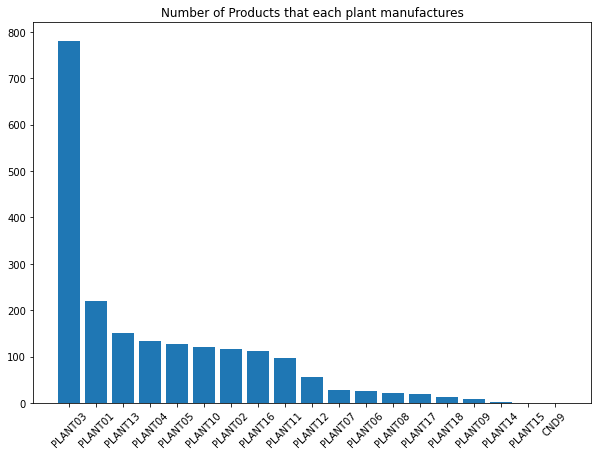

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
plant_counts = pd.DataFrame(products_plants["Plant_Code"].value_counts())
ax.bar(plant_counts.index, plant_counts["Plant_Code"])
plt.title("Number of Products that each plant manufactures")
plt.show()

La primera gráfica muestra el número de productos que cada planta manufactura. La segunda gráfica muestra el costo de manufactura para cada planta. Ambas gráficas muestran la información en un eje de coordenadas x con etiquetas rotadas en 45 grados.

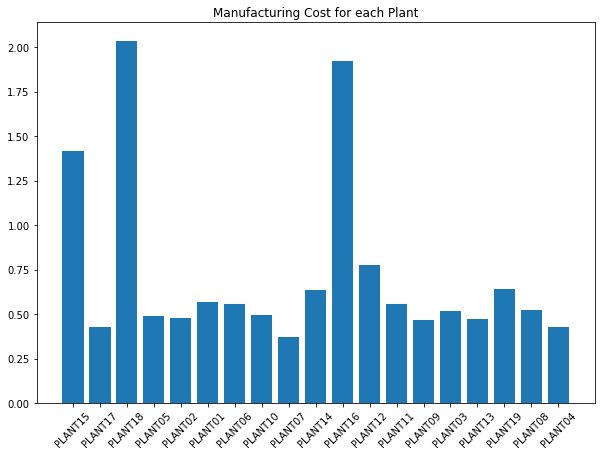

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
ax.bar(wh_cost.index, wh_cost["Cost/unit"])
plt.title("Manufacturing Cost for each Plant")
plt.show()